# Test 3 - Blind reasoning

In [22]:
! tar czf Testing.tar *

In [1]:
! nvidia-smi

Tue Sep  9 22:29:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
| 42%   53C    P8             32W /  450W |      15MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import textworld
import textworld.gym

In [ ]:
import time
import re
import os
from glob import glob
from typing import Mapping, Any

import pickle
import random

In [ ]:
import torch

torch.set_default_device('cuda')
torch.cuda.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

In [ ]:
from ..Self_evaluation.self_evaluation import play, LLMAgentSelfEvaluate

## Game generation

In [2]:
max_steps = 100
n_episodes = 10

In [3]:
# 1 to 10
seeds = range(1,11)

In [ ]:
# 0 to 9
seeds = range(10)

In [ ]:
# polietilene
seeds = [6, 10, 20, 45, 46, 89, 1863, 2022, 79010123, 1179382318]

In [ ]:
!tw-make tw-simple --rewards dense --goal detailed --seed 0 --test --silent -f --output games/test-seed0.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 1 --test --silent -f --output games/test-seed1.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 2 --test --silent -f --output games/test-seed2.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 3 --test --silent -f --output games/test-seed3.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 4 --test --silent -f --output games/test-seed4.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 5 --test --silent -f --output games/test-seed5.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 6 --test --silent -f --output games/test-seed6.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 7 --test --silent -f --output games/test-seed7.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 8 --test --silent -f --output games/test-seed8.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 9 --test --silent -f --output games/test-seed9.z8
!tw-make tw-simple --rewards dense --goal detailed --seed 10 --test --silent -f --output games/test-seed10.z8

## Game running

# Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [5]:
results_nothink = []
results_fullthink = []
results_5think = []
results_10think = []

for seed in seeds:
    with open(f'Testing 2/nothink_seed{seed}.pickle', 'rb') as f:
        results_nothink.append(pickle.load(f))
        f.close()
    with open(f'Testing 2/fullthink_seed{seed}.pickle', 'rb') as f:
        results_fullthink.append(pickle.load(f))
        f.close()
    with open(f'Testing 2/5-think_seed{seed}.pickle', 'rb') as f:
        results_5think.append(pickle.load(f))
        f.close()
    with open(f'Testing 2/10-think_seed{seed}.pickle', 'rb') as f:
        results_10think.append(pickle.load(f))
        f.close()

In [7]:
max_scores = [8, 10, 7, 10, 7, 10, 7, 10, 7, 7]

avg_scores_nothink = []
std_nothink = []
bs_nothink = []
avg_scores_fullthink = []
std_fullthink = []
bs_fullthink = []
avg_scores_5think = []
std_5think = []
bs_5think = []
avg_scores_10think = []
std_10think = []
bs_10think = []
results_scores_std = [(results_nothink, avg_scores_nothink, std_nothink, bs_nothink),
                (results_fullthink, avg_scores_fullthink, std_fullthink, bs_fullthink),
                (results_5think, avg_scores_5think, std_5think, bs_5think),
                (results_10think, avg_scores_10think, std_10think, bs_10think)]

for model in results_scores_std:
    results, avg_scores, std, bs = model
    for seed in seeds:
        scores_of_final_steps = []
        runs = results[seed-1]
        for run in runs:
            scores_of_final_steps.append(run[-1][1]) # 2nd parameter (aka score) of last step
        avg_scores.append(np.mean(scores_of_final_steps) / max_scores[seed-1])
        std.append(np.std(scores_of_final_steps) / max_scores[seed-1])
        bootstrap_results = bootstrap(data=(np.array(scores_of_final_steps)/max_scores[seed-1],), 
                              statistic=np.mean,
                              method="basic",
                              n_resamples=1000,
                              confidence_level=0.9)
        bs.append((bootstrap_results.confidence_interval.high, bootstrap_results.confidence_interval.low))        
        

In [10]:
print(avg_scores_nothink)
print(std_nothink)

[np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.55), np.float64(0.5714285714285714), np.float64(0.9099999999999999), np.float64(1.0), np.float64(0.93), np.float64(1.0), np.float64(1.0)]
[np.float64(0.39999999999999997), np.float64(2.0), np.float64(0.0), np.float64(3.5), np.float64(0.0), np.float64(0.3), np.float64(0.0), np.float64(0.45825756949558394), np.float64(0.0), np.float64(0.0)]


In [8]:
avg_times_nothink = []
std_times_nothink = []
avg_times_fullthink = []
std_times_fullthink = []
avg_times_5think = []
std_times_5think = []
avg_times_10think = []
std_times_10think = []
results_times_std = [(results_nothink, avg_times_nothink, std_times_nothink),
                (results_fullthink, avg_times_fullthink, std_times_fullthink),
                (results_5think, avg_times_5think, std_times_5think),
                (results_10think, avg_times_10think, std_times_10think)]

for model in results_times_std:
    results, avg_times, std_times = model
    for seed in seeds:
        times_of_final_steps = []
        runs = results[seed-1]
        for run in runs:
            times_of_final_steps.append(run[-1][2]) # 3rd parameter (aka time) of last step
        avg_times.append(np.mean(times_of_final_steps))
        std_times.append(np.std(times_of_final_steps))

In [14]:
print(avg_times_nothink)
print(std_times_nothink)

[np.float64(28.4300772543), np.float64(31.763657541000008), np.float64(1.2399932578999937), np.float64(49.19406693649997), np.float64(26.704977851600052), np.float64(41.891900372500004), np.float64(1.5536869351000178), np.float64(33.5945569876), np.float64(1.672821979199989), np.float64(1.3906766267999955)]
[np.float64(7.271113320052689), np.float64(4.086677958081168), np.float64(0.004464711384229425), np.float64(9.259104943745719), np.float64(2.4320823159558485), np.float64(13.269587689239584), np.float64(0.08873939433606111), np.float64(19.99668164072732), np.float64(0.07812321248657635), np.float64(0.1693432629715951)]


In [9]:
figsize=(7,7)

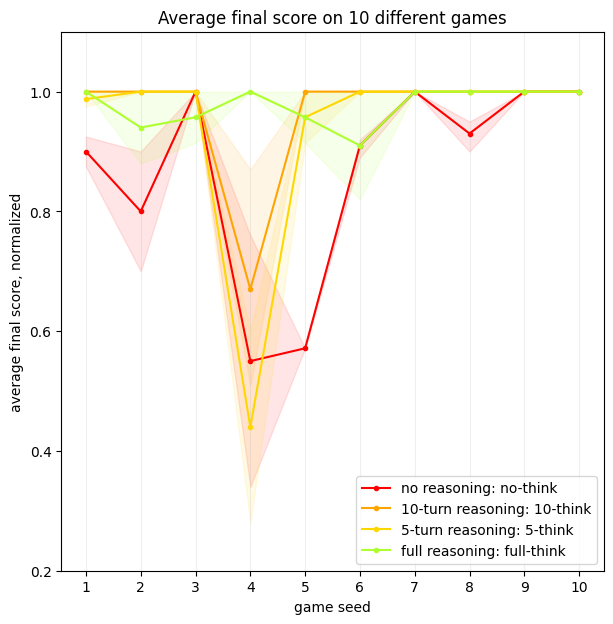

In [13]:
x = list(seeds) # converting into a list just to be sure, maybe an iterator doesn't work here

fig, ax = plt.subplots(figsize=figsize)

ax.plot(x, avg_scores_nothink, label="no reasoning: no-think", marker=".", linestyle="-", color="red")
ax.plot(x, avg_scores_10think, label="10-turn reasoning: 10-think", marker=".", linestyle="-", color="orange")
ax.plot(x, avg_scores_5think, label="5-turn reasoning: 5-think", marker=".", linestyle="-", color="gold")
ax.plot(x, avg_scores_fullthink, label="full reasoning: full-think", marker=".", linestyle="-", color="greenyellow")

# ax.fill_between(x,
#                 np.clip([np.array(avg_scores_nothink) + np.array(std_nothink)], 0, 1),
#                 np.clip(np.array(avg_scores_nothink) - np.array(std_nothink), 0, 1),
#                 alpha=0.05, color="red")
# ax.fill_between(x,
#                 np.clip(np.array(avg_scores_10think) + np.array(std_10think), 0, 1),
#                 np.clip(np.array(avg_scores_10think) - np.array(std_10think), 0, 1),
#                 alpha=0.05, color="orange")
# ax.fill_between(x,
#                 np.clip(np.array(avg_scores_5think) + np.array(std_5think), 0, 1),
#                 np.clip(np.array(avg_scores_5think) - np.array(std_5think), 0, 1),
#                 alpha=0.05, color="gold")
# ax.fill_between(x,
#                 np.clip(np.array(avg_scores_fullthink) + np.array(std_fullthink), 0, 1),
#                 np.clip(np.array(avg_scores_fullthink) - np.array(std_fullthink), 0, 1),
#                 alpha=0.05, color="greenyellow")

ax.fill_between(x,
                np.clip([i[0] for i in bs_nothink], 0, 1),
                np.clip([i[1] for i in bs_nothink], 0, 1),
                alpha=0.1, color="red")
ax.fill_between(x,
                np.clip([i[0] for i in bs_10think], 0, 1),
                np.clip([i[1] for i in bs_10think], 0, 1),
                alpha=0.1, color="orange")
ax.fill_between(x,
                np.clip([i[0] for i in bs_5think], 0, 1),
                np.clip([i[1] for i in bs_5think], 0, 1),
                alpha=0.1, color="gold")
ax.fill_between(x,
                np.clip([i[0] for i in bs_fullthink], 0, 1),
                np.clip([i[1] for i in bs_fullthink], 0, 1),
                alpha=0.1, color="greenyellow")


ax.set_title("Average final score on 10 different games")
ax.set_xlabel('game seed')
ax.set_ylabel('average final score, normalized')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.set_ylim(0.2, 1.1)

ax.legend()
plt.show()

In [15]:
final_scores_nothink = np.array([[results_nothink[i][j][-1][1] / max_scores[i] for j in range(n_episodes)] for i in range(len(seeds))])
final_scores_10think = np.array([[results_10think[i][j][-1][1] / max_scores[i] for j in range(n_episodes)] for i in range(len(seeds))])
final_scores_5think = np.array([[results_5think[i][j][-1][1] / max_scores[i] for j in range(n_episodes)] for i in range(len(seeds))])
final_scores_fullthink = np.array([[results_fullthink[i][j][-1][1] / max_scores[i] for j in range(n_episodes)] for i in range(len(seeds))])



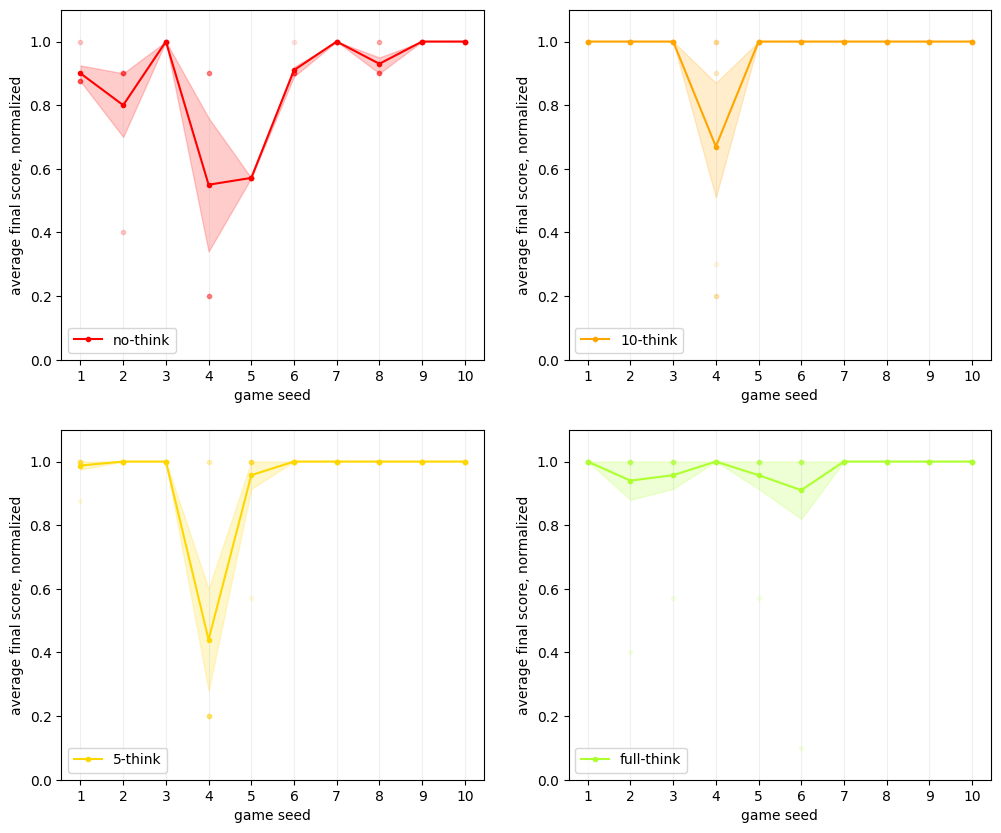

In [16]:
x = list(seeds) # converting into a list just to be sure, maybe an iterator doesn't work here

fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize=(12,10))

ax1.plot(x, avg_scores_nothink, label="no-think", marker=".", linestyle="-", color="red")
ax2.plot(x, avg_scores_10think, label="10-think", marker=".", linestyle="-", color="orange")
ax3.plot(x, avg_scores_5think, label="5-think", marker=".", linestyle="-", color="gold")
ax4.plot(x, avg_scores_fullthink, label="full-think", marker=".", linestyle="-", color="greenyellow")

for run in range(n_episodes):
    ax1.plot(x, [seed_runs[run] for seed_runs in final_scores_nothink],  marker=".", linestyle="", color="red", alpha=0.1)
    ax2.plot(x, [seed_runs[run] for seed_runs in final_scores_10think],  marker=".", linestyle="", color="orange", alpha=0.1)
    ax3.plot(x, [seed_runs[run] for seed_runs in final_scores_5think],  marker=".", linestyle="", color="gold", alpha=0.1)
    ax4.plot(x, [seed_runs[run] for seed_runs in final_scores_fullthink], marker=".", linestyle="", color="greenyellow", alpha=0.1)

ax1.fill_between(x,
                np.clip([i[0] for i in bs_nothink], 0, 1),
                np.clip([i[1] for i in bs_nothink], 0, 1),
                alpha=0.2, color="red")
ax2.fill_between(x,
                np.clip([i[0] for i in bs_10think], 0, 1),
                np.clip([i[1] for i in bs_10think], 0, 1),
                alpha=0.2, color="orange")
ax3.fill_between(x,
                np.clip([i[0] for i in bs_5think], 0, 1),
                np.clip([i[1] for i in bs_5think], 0, 1),
                alpha=0.2, color="gold")
ax4.fill_between(x,
                np.clip([i[0] for i in bs_fullthink], 0, 1),
                np.clip([i[1] for i in bs_fullthink], 0, 1),
                alpha=0.2, color="greenyellow")

gridlines = np.arange(x[0], x[-1]+1, 1)
for ax in (ax1, ax2, ax3, ax4):
    
    ax.set_xlabel('game seed')
    ax.set_ylabel('average final score, normalized')

    ax.set_xticks(gridlines)
    ax.grid(axis="x", alpha=0.2)
    ax.set_ylim(0, 1.1)

    ax.legend()

#fig.suptitle("Average final score on 10 different games")


plt.show()

In [17]:
final_times_nothink = np.array([[results_nothink[i][j][-1][2] for j in range(n_episodes)] for i in range(len(seeds))])
final_times_10think = np.array([[results_10think[i][j][-1][2] for j in range(n_episodes)] for i in range(len(seeds))])
final_times_5think = np.array([[results_5think[i][j][-1][2] for j in range(n_episodes)] for i in range(len(seeds))])
final_times_fullthink = np.array([[results_fullthink[i][j][-1][2] for j in range(n_episodes)] for i in range(len(seeds))])

In [37]:
print(final_times_nothink)

[[33.44082175 30.86483702 30.77464157 30.78710304 32.89632226 13.7146945
  33.23591494 30.91406891 14.38528772 33.28708083]
 [32.76361803 33.19332207 36.36515928 32.15418398 32.14945282 24.34477655
  32.19429985 32.78355035 37.34540457 24.34280791]
 [ 1.24221499  1.23948321  1.22679593  1.24138543  1.24129717  1.24173242
   1.24140146  1.24230919  1.24211969  1.24119309]
 [39.83008991 39.46212736 40.57330785 58.62509869 38.79872906 58.39197066
  58.38372493 58.39565934 41.10070883 58.37925275]
 [24.35278301 28.64526022 28.41518026 24.90780175 27.49614129 25.58470065
  24.32045644 25.29270418 25.59375819 32.44099254]
 [46.29490308 46.29794208 46.31487582 46.27103362  2.0832261  46.28344333
  46.33555477 46.32449764 46.34603711 46.36749018]
 [ 1.50193229  1.49553585  1.48723758  1.49295863  1.50726001  1.69163655
   1.49125182  1.49372561  1.68630691  1.6890241 ]
 [45.29270557 49.52445454 49.5890779  49.6016912  49.58394205 42.57462463
  39.42330267  3.45861889  3.44856378  3.44858864]
 

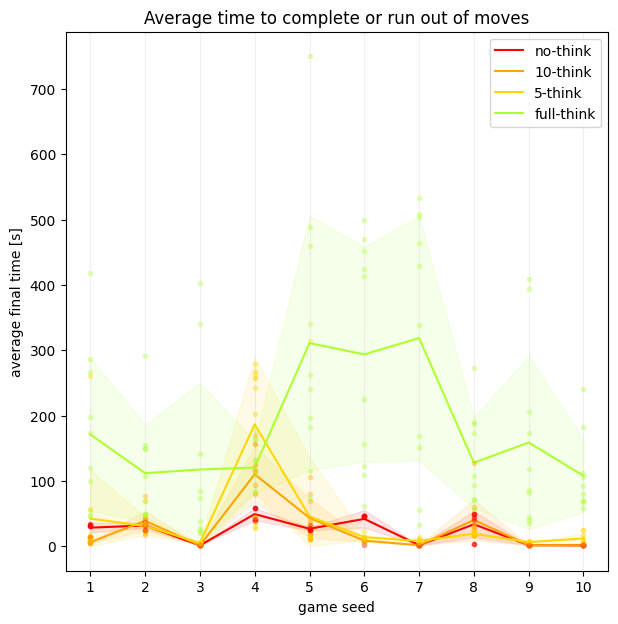

In [19]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, avg_times_nothink, label="no-think", marker="", linestyle="-", color="red")
ax.plot(x, avg_times_10think, label="10-think", marker="", linestyle="-", color="orange")
ax.plot(x, avg_times_5think, label="5-think", marker="", linestyle="-", color="gold")
ax.plot(x, avg_times_fullthink, label="full-think", marker="", linestyle="-", color="greenyellow")

ax.fill_between(x, np.array(avg_times_nothink) + np.array(std_times_nothink), np.clip(np.array(avg_times_nothink) - np.array(std_times_nothink), 0, None), alpha=0.1, color="red")
ax.fill_between(x, np.array(avg_times_10think) + np.array(std_times_10think), np.clip(np.array(avg_times_10think) - np.array(std_times_10think), 0, None), alpha=0.1, color="orange")
ax.fill_between(x, np.array(avg_times_5think) + np.array(std_times_5think), np.clip(np.array(avg_times_5think) - np.array(std_times_5think), 0, None), alpha=0.1, color="gold")
ax.fill_between(x, np.array(avg_times_fullthink) + np.array(std_times_fullthink), np.clip(np.array(avg_times_fullthink) - np.array(std_times_fullthink), 0, None), alpha=0.1, color="greenyellow")

for run in range(n_episodes):
    ax.plot(x, [seed_runs[run] for seed_runs in final_times_nothink],  marker=".", linestyle="", color="red", alpha=0.3)
    ax.plot(x, [seed_runs[run] for seed_runs in final_times_10think],  marker=".", linestyle="", color="orange", alpha=0.3)
    ax.plot(x, [seed_runs[run] for seed_runs in final_times_5think],  marker=".", linestyle="", color="gold", alpha=0.3)
    ax.plot(x, [seed_runs[run] for seed_runs in final_times_fullthink], marker=".", linestyle="", color="greenyellow", alpha=0.3)

ax.set_title("Average time to complete or run out of moves")
ax.set_xlabel('game seed')
ax.set_ylabel('average final time [s]')

gridlines = np.arange(x[0], x[-1]+1, 1)
ax.set_xticks(gridlines)
ax.grid(axis="x", alpha=0.2)

ax.legend()
plt.show()

# Bundles of tries

In [ ]:
# better to use a seed with 10 total score, for clarity
bundle_seed = 11
!tw-make tw-simple --rewards dense --goal detailed --seed 11 --test --silent -f --output games/test-seed11.z8

In [ ]:
results = play(LLMAgentSelfEvaluate(selfeval_turns = -1, handheld=False, verbose=False),
        f"./games/test-seed{bundle_seed}.z8", max_steps=max_steps, n_episodes=n_episodes)

with open(f'./Testing 2/nothink_seed{seed}.pickle', 'wb') as f:
    pickle.dump(results, f)
    print("Data pickled.")
    f.close()

In [ ]:
results = play(LLMAgentSelfEvaluate(selfeval_turns = 10, handheld=False, verbose=False),
        f"./games/test-seed{bundle_seed}.z8", max_steps=max_steps, n_episodes=n_episodes)

with open(f'./Testing 2/10-think_seed{seed}.pickle', 'wb') as f:
    pickle.dump(results, f)
    print("Data pickled.")
    f.close()

In [67]:
# temporary override
bundle_seed = 4
max_score_bundle = max_scores[bundle_seed-1]

In [68]:
cum_score_index = 1 # (step number, cumulative score, timestamp from beginning of episode)

bundle_nothink = []
bundle_10think = []
bundle_5think = []
bundle_fullthink = []
cum_scores_nothink = []
cum_scores_10think = []
cum_scores_5think = []
cum_scores_fullthink = []

with open(f'Testing 2/nothink_seed{bundle_seed}.pickle', 'rb') as f:
    bundle_nothink = pickle.load(f)
    f.close()
with open(f'Testing 2/10-think_seed{bundle_seed}.pickle', 'rb') as f:
    bundle_10think = pickle.load(f)
    f.close()
with open(f'Testing 2/5-think_seed{bundle_seed}.pickle', 'rb') as f:
    bundle_5think = pickle.load(f)
    f.close()
with open(f'Testing 2/fullthink_seed{bundle_seed}.pickle', 'rb') as f:
    bundle_fullthink = pickle.load(f)
    f.close()

bundles_cum_scores = [(bundle_nothink, cum_scores_nothink), (bundle_10think, cum_scores_10think), (bundle_5think, cum_scores_5think), (bundle_fullthink, cum_scores_fullthink)]

for i in range(n_episodes):
    for bundle, cum_scores in bundles_cum_scores:
        single_run = []
        for step in bundle[i]:
            single_run.append(step[cum_score_index])
        cum_scores.append(single_run)   

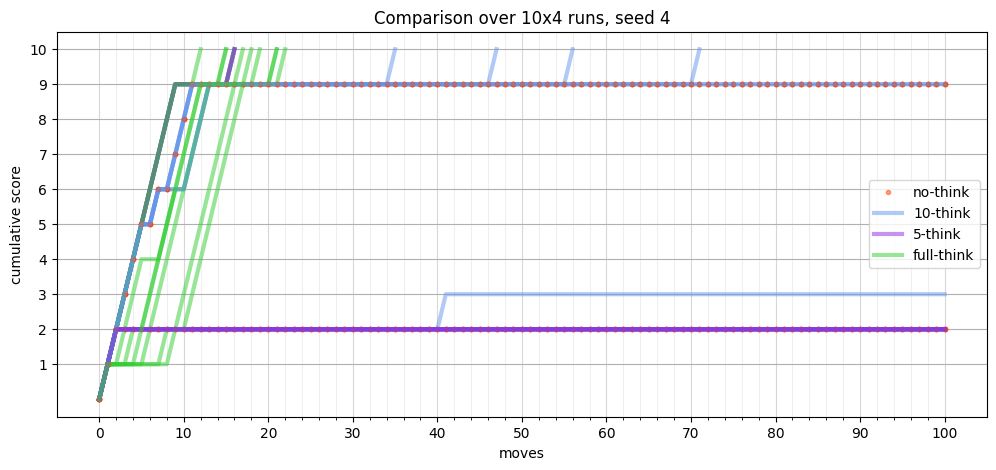

In [78]:
fig, ax = plt.subplots(figsize=(12,5))
moves = np.arange(0, max_steps+1, 1)

for i in range(n_episodes):
    if i == 0: # set labels just once
        ax.plot(moves[:len(cum_scores_nothink[i])], cum_scores_nothink[i], marker=".", linestyle="", linewidth=2, color="orangered", alpha=0.5, label="no-think")
        ax.plot(moves[:len(cum_scores_10think[i])], cum_scores_10think[i], marker="", linestyle="-", linewidth=3, color="cornflowerblue", alpha=0.5, label = "10-think")
        ax.plot(moves[:len(cum_scores_5think[i])], cum_scores_5think[i], marker="", linestyle="-", linewidth=3, color="blueviolet", alpha=0.5, label="5-think")
        ax.plot(moves[:len(cum_scores_fullthink[i])], cum_scores_fullthink[i], marker="", linestyle="-", linewidth=3, color="limegreen", alpha=0.5, label = "full-think")
    else:
        ax.plot(moves[:len(cum_scores_nothink[i])], cum_scores_nothink[i], marker=".", linestyle="", linewidth=2, color="orangered", alpha=0.5)
        ax.plot(moves[:len(cum_scores_10think[i])], cum_scores_10think[i], marker="", linestyle="-", linewidth=3, color="cornflowerblue", alpha=0.5)
        ax.plot(moves[:len(cum_scores_5think[i])], cum_scores_5think[i], marker="", linestyle="-", linewidth=3, color="blueviolet", alpha=0.5)
        ax.plot(moves[:len(cum_scores_fullthink[i])], cum_scores_fullthink[i], marker="", linestyle="-", linewidth=3, color="limegreen", alpha=0.5)


ax.set_title(f"Comparison over 10x4 runs, seed {bundle_seed}")
ax.set_xlabel('moves')
ax.set_ylabel('cumulative score')

major_ticks = np.arange(0, max_steps+1, 10)
minor_ticks = np.arange(0, max_steps+1, 2)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(axis="x", which='minor', alpha=0.2)
ax.grid(axis="x", which='major', alpha=0.5)
# ax.minorticks_on()

ticks_y = np.arange(1, max_score_bundle+1, 1)
ax.set_yticks(ticks_y)
ax.grid(axis="y")


ax.legend()
plt.show()